# Data Processing

This notebook loads artifacts written under `LD_benchmark/results/<YYYYMMDD>/...` and plots:

1. Toy: 2D trajectory path
2. Small-batch: 3D trajectory path
3. CSTR: objective + CPU time vs `NT`, plus 2D trajectory for `NT=30`
4. Column: objective + CPU time vs initialization key

**Algorithm selection:** set `ALGORITHMS_TO_PLOT = ['LDSDA']`, `['LDBD']`, or `['LDSDA','LDBD']` in the setup cell below.

In [4]:
# Generate the stamp for today's date
from datetime import datetime
today = str(datetime.now().strftime("%Y%m%d"))
print(today)

20260225


In [20]:
from __future__ import annotations
from pathlib import Path
import sys
import pandas as pd

# ---- User settings ----
# Which algorithms to plot: set to ['LDSDA'], ['LDBD'], or ['LDSDA','LDBD']
ALGORITHMS_TO_PLOT = ["LDSDA", "LDBD"]

# Optional: override date stamp (defaults to today's stamp from the prior cell)
# today = "YYYYMMDD"

# ---- Locate LD_benchmark root and results directory for `today` ----
cwd = Path.cwd().resolve()

def _find_ld_root(start: Path) -> Path:
    if (start / "models").is_dir() and (start / "results").is_dir():
        return start
    if (start / "LD_benchmark" / "models").is_dir():
        return start / "LD_benchmark"
    for parent in [start] + list(start.parents):
        if (parent / "models").is_dir() and (parent / "results").is_dir():
            return parent
        if (parent / "LD_benchmark" / "models").is_dir():
            return parent / "LD_benchmark"
    raise FileNotFoundError(f"Cannot find LD_benchmark root from {start}")

ld_root = _find_ld_root(cwd)
results_day_dir = ld_root / "results" / today
results_day_dir.mkdir(parents=True, exist_ok=True)

# ---- Asset CSVs for heatmaps/landscapes ----
# These are precomputed landscapes used for heatmap-style plots.
assets_dir = ld_root / "assets"
SMALL_BATCH_ENUM_CSV = assets_dir / "compl_enum_small_batch_baron.csv"
CSTR_ENUM_CSV = assets_dir / "compl_enum_cstr_30_baron_dantzig.csv"
COLUMN_ENUM_CSV = assets_dir / "compl_enum_column_17_optimal_baron_bigm.csv"

def _normalize_algo_tag(name: str) -> str:
    x = str(name).strip().lower()
    if x in {"ldsda", "gdpopt.ldsda"}:
        return "LDSDA"
    if x in {"ldbd", "gdpopt.ldbd"}:
        return "LDBD"
    return str(name).strip().upper()

def _selected_algorithms() -> list[str]:
    algos = [_normalize_algo_tag(a) for a in (ALGORITHMS_TO_PLOT or [])]
    # de-dup while preserving order
    out: list[str] = []
    for a in algos:
        if a not in out:
            out.append(a)
    return out

def load_traj(traj_csv: Path) -> list[tuple[int, ...]]:
    """Load a trajectory saved by the benchmark runner (`traj.csv`)."""
    if not traj_csv.exists():
        return []
    df = pd.read_csv(traj_csv)
    e_cols = [c for c in df.columns if c.startswith("e")]
    points: list[tuple[int, ...]] = []
    for _, row in df.iterrows():
        coords = tuple(int(row[c]) for c in e_cols if pd.notna(row[c]))
        if coords:
            points.append(coords)
    return points

def load_summaries_under(subdir: str) -> pd.DataFrame:
    """Load all `summary.csv` files beneath results/<today>/<subdir>/ (recursive)."""
    base = results_day_dir / subdir
    if not base.exists():
        return pd.DataFrame()
    paths = sorted(base.rglob("summary.csv"))
    if not paths:
        return pd.DataFrame()
    dfs: list[pd.DataFrame] = []
    for p in paths:
        try:
            d = pd.read_csv(p)
        except Exception:
            continue
        d["__file"] = str(p)
        dfs.append(d)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

def filter_by_algorithms(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df
    selected = set(_selected_algorithms())
    if not selected:
        return df
    if "algorithm" not in df.columns:
        return df
    alg_col = df["algorithm"].map(_normalize_algo_tag)
    return df[alg_col.isin(selected)].copy()

print("LD_benchmark root:", ld_root)
print("Results dir:", results_day_dir)
print("Algorithms to plot:", _selected_algorithms())
print("Assets dir:", assets_dir)

LD_benchmark root: D:\Data\Proj\SECQUOIA\Pyomos\LD_benchmark
Results dir: D:\Data\Proj\SECQUOIA\Pyomos\LD_benchmark\results\20260225
Algorithms to plot: ['LDSDA', 'LDBD']
Assets dir: D:\Data\Proj\SECQUOIA\Pyomos\LD_benchmark\assets


## Mathematical illustrative example

In [6]:
# Load toy trajectories produced by ModelTestingScript into variables used for plotting
import os

folder_path = results_day_dir
os.makedirs(folder_path, exist_ok=True)

toy_points: dict[str, list[tuple[int, ...]]] = {}
for alg in _selected_algorithms():
    traj_csv = folder_path / "toy" / alg.lower() / "traj.csv"
    toy_points[alg] = load_traj(traj_csv)

print("Toy traj lengths:", {k: len(v) for k, v in toy_points.items()})

Toy traj lengths: {'LDSDA': 8, 'LDBD': 7}


In [ ]:
import matplotlib.pyplot as plt

def _style_fixed_2d_axes(
    ax,
    *,
    xlim,
    ylim,
    xticks,
    yticks,
    xlabel="e1",
    ylabel="e2",
    grid=True,
 ):
    # Inner ticks + bold tick labels
    ax.tick_params(axis='both', which='both', direction='in', labelsize=16, width=2, length=6, top=True, right=True)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    # Thicker axis spines
    axis_thickness = 2.5
    for spine in ax.spines.values():
        spine.set_linewidth(axis_thickness)

    # Fixed integer grid (no dynamic limits)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_xticks(list(xticks))
    ax.set_yticks(list(yticks))

    ax.set_xlabel(xlabel, fontsize=18, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=18, fontweight='bold')

    if grid:
        ax.grid(True, which='major', linestyle=':', alpha=0.6, lw=1.5)

def plot_point_sequence(
    points,
    figure_path=None,
    title=None,
    *,
    xlim=(0.5, 5.5),
    ylim=(0.5, 5.5),
    xticks=(1, 2, 3, 4, 5),
    yticks=(1, 2, 3, 4, 5),
 ):
    """Plot a 2D trajectory with arrows, using fixed axes (no dynamic xlim/ylim)."""
    if not points:
        print("No trajectory points to plot.")
        return

    if any(len(p) < 2 for p in points):
        raise ValueError("Expected 2D points for this plot")

    fig, ax = plt.subplots(figsize=(7, 7))

    # 1) Sequential path with arrows
    for i in range(len(points) - 1):
        ax.annotate(
            "",
            xy=points[i + 1],
            xytext=points[i],
            arrowprops=dict(arrowstyle='->', color='royalblue', lw=2, mutation_scale=20),
        )

    # 2) Scatter points + step labels
    e1_coords = [p[0] for p in points]
    e2_coords = [p[1] for p in points]
    ax.scatter(e1_coords, e2_coords, color='crimson', s=120, zorder=5)
    for i, (x, y) in enumerate(points):
        ax.text(x, y + 0.15, str(i + 1), fontsize=16, color='darkred', fontweight='bold', ha='center', va='bottom')

    # 3) Fixed axes styling
    _style_fixed_2d_axes(ax, xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks)

    ax.set_title(title or 'Point Sequence', fontsize=18, fontweight='bold')
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()

def plot_2d_paths(
    points_by_alg: dict[str, list[tuple[int, ...]]],
    title: str,
    *,
    xlim=(0.5, 5.5),
    ylim=(0.5, 5.5),
    xticks=(1, 2, 3, 4, 5),
    yticks=(1, 2, 3, 4, 5),
 ):
    """Combined 2D plot with arrows, using the same fixed-axis style."""
    fig, ax = plt.subplots(figsize=(7, 7))

    style = {
        "LDSDA": {"color": "red", "marker": "o"},
        "LDBD": {"color": "black", "marker": "s"},
    }

    for alg, pts in points_by_alg.items():
        if not pts:
            continue
        st = style.get(alg, {"color": "gray", "marker": "o"})

        for i in range(len(pts) - 1):
            ax.annotate(
                "",
                xy=pts[i + 1],
                xytext=pts[i],
                arrowprops=dict(arrowstyle='->', color=st["color"], lw=2, mutation_scale=18),
            )

        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        ax.plot(xs, ys, color=st["color"], lw=2, marker=st["marker"], label=alg)

        y_off = 0.15 if alg == "LDSDA" else -0.25
        for k, (x, y) in enumerate(pts, start=1):
            ax.text(x, y + y_off, str(k), fontsize=12, color=st["color"], fontweight='bold', ha='center', va='bottom')

    _style_fixed_2d_axes(ax, xlim=xlim, ylim=ylim, xticks=xticks, yticks=yticks)
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.legend()
    plt.show()

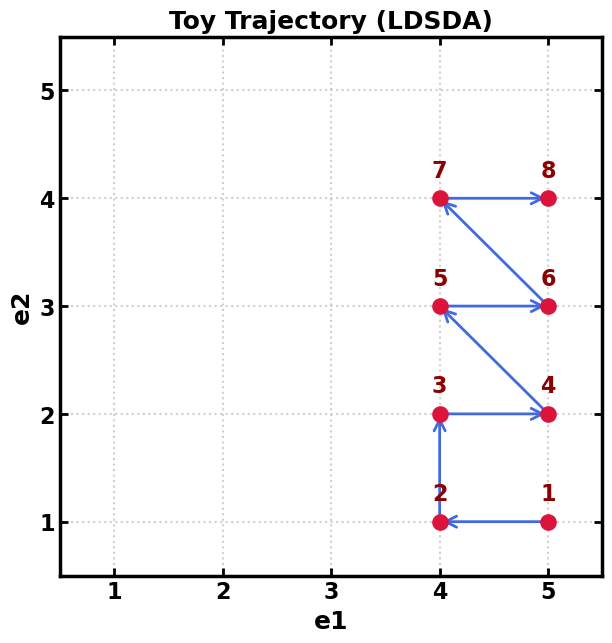

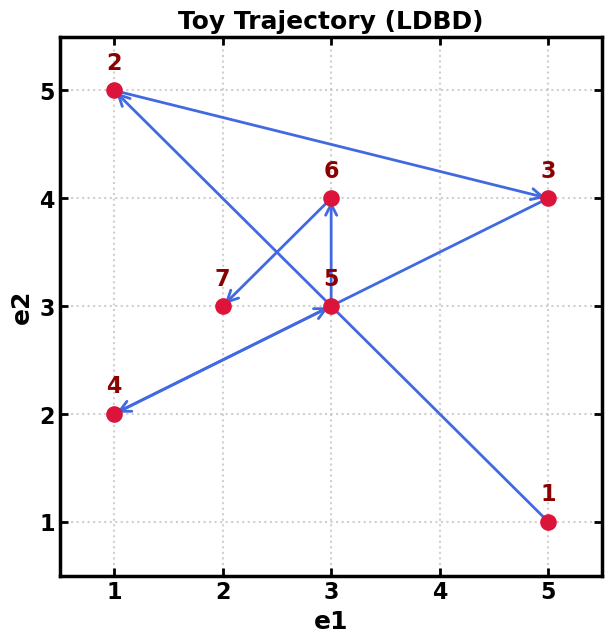

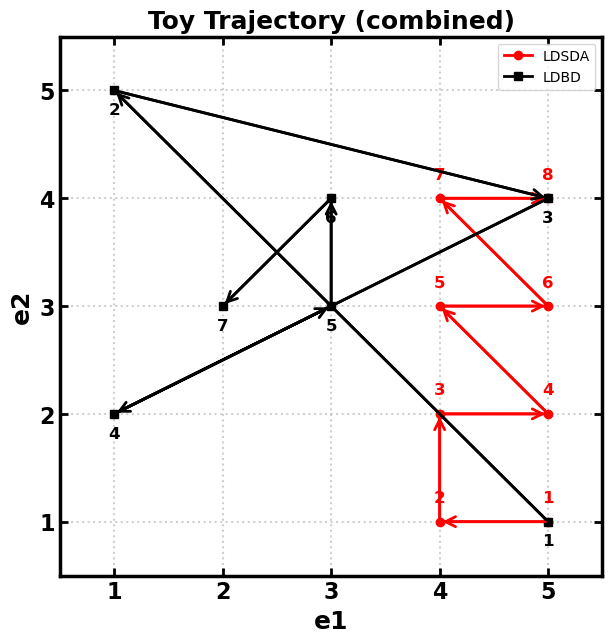

In [33]:
# Toy: plot either one algorithm or both (based on ALGORITHMS_TO_PLOT)
import os

# Per-algorithm plots
for alg, pts in toy_points.items():
    plot_point_sequence(pts, os.path.join(folder_path, f"toy_{alg.lower()}_traj_{today}.png"), title=f"Toy Trajectory ({alg})")

# Combined plot (if both are present)
plot_2d_paths(toy_points, title="Toy Trajectory (combined)")

## Small batch


In [30]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from matplotlib.ticker import MaxNLocator

def plot_3d_path_with_missing_nodes(
    df: pd.DataFrame,
    sequence: list[tuple[int, ...]],
    figure_path: str | None = None,
    title: str | None = None,
    *,
    cmap_name: str = "viridis",
    show_missing: bool = True,
    arrow_length: float = 0.5,
    arrow_ratio: float = 0.3,
 ):
    """
    Small-batch 3D plot in the same style as results/20260216/20260216.ipynb.

    Key behaviors (match notebook):
    - Axis limits are fixed to 0.1..4.1 and ticks are fixed to [1,2,3,4].
    - Points from the enumeration CSV are colored by Objective.
    - Missing/unexplored nodes on the full 1..4 grid are shown as hollow triangles.
    - The visited sequence is drawn with a blue line + quiver arrows and red step labels.
    """
    if df.empty:
        raise ValueError("Empty enumeration dataframe for small-batch plot")

    required = {"x", "y", "z", "Objective"}
    missing_cols = required - set(df.columns)
    if missing_cols:
        raise ValueError(f"Enumeration dataframe missing columns: {sorted(missing_cols)}")

    df2 = df.dropna(subset=["x", "y", "z", "Objective"]).copy()
    df2["x"] = df2["x"].astype(int)
    df2["y"] = df2["y"].astype(int)
    df2["z"] = df2["z"].astype(int)
    df2["Objective"] = df2["Objective"].astype(float)

    fig = plt.figure(figsize=(11, 11))
    ax = fig.add_subplot(111, projection="3d")

    cmap = plt.get_cmap(cmap_name)
    scatter = ax.scatter(
        df2["x"],
        df2["y"],
        df2["z"],
        c=df2["Objective"],
        cmap=cmap,
        s=100,
        label="Optimal Points",
        edgecolors="k",
        zorder=5,
    )

    # Fixed full grid 1..4 (match 20260216 notebook)
    if show_missing:
        all_coords = {(i, j, k) for i in range(1, 5) for j in range(1, 5) for k in range(1, 5)}
        existing_coords = set(zip(df2["x"], df2["y"], df2["z"]))
        missing_coords = list(all_coords - existing_coords)
        if missing_coords:
            mx, my, mz = zip(*missing_coords)
            ax.scatter(
                mx,
                my,
                mz,
                marker="^",
                facecolors="none",
                edgecolors="gray",
                s=60,
                alpha=0.3,
                label="Infeasible/Missing",
            )

    seq = [(int(p[0]), int(p[1]), int(p[2])) for p in (sequence or []) if len(p) >= 3]
    if seq:
        for i in range(len(seq) - 1):
            start = seq[i]
            end = seq[i + 1]
            ax.plot(
                [start[0], end[0]],
                [start[1], end[1]],
                [start[2], end[2]],
                color="blue",
                lw=2,
                zorder=10,
            )
            ax.quiver(
                start[0],
                start[1],
                start[2],
                end[0] - start[0],
                end[1] - start[1],
                end[2] - start[2],
                length=arrow_length,
                color="blue",
                normalize=True,
                arrow_length_ratio=arrow_ratio,
            )

        for idx, (px, py, pz) in enumerate(seq, start=1):
            ax.text(px, py, pz + 0.1, str(idx), color="red", fontsize=16, fontweight="bold")
    else:
        ax.text2D(0.05, 0.95, "No trajectory found", transform=ax.transAxes)

    # Integer-only ticks (and fixed tick labels)
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.set_major_locator(MaxNLocator(integer=True))

    ax.set_xlim(0.1, 4.1)
    ax.set_ylim(0.1, 4.1)
    ax.set_zlim(0.1, 4.1)
    ax.set_xticks([1, 2, 3, 4])
    ax.set_yticks([1, 2, 3, 4])
    ax.set_zticks([1, 2, 3, 4])

    ax.tick_params(axis="both", which="major", direction="in", labelsize=12, pad=5)
    ax.set_xlabel('Number of Mixers ($Z_E$)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('Number of Reactors ($Z_E$)', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_zlabel('Number of Centrifuges ($Z_E$)', fontsize=14, fontweight='bold', labelpad=10)

    fig.colorbar(scatter, ax=ax, label="Objective Value", pad=0.1, shrink=0.6)
    ax.set_title(title if title else "3D Path Visualization", fontsize=18, fontweight="bold")
    plt.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

    if figure_path:
        plt.savefig(figure_path, bbox_inches="tight")
    plt.show()

Small-batch traj lengths: {'LDSDA': 12, 'LDBD': 6}


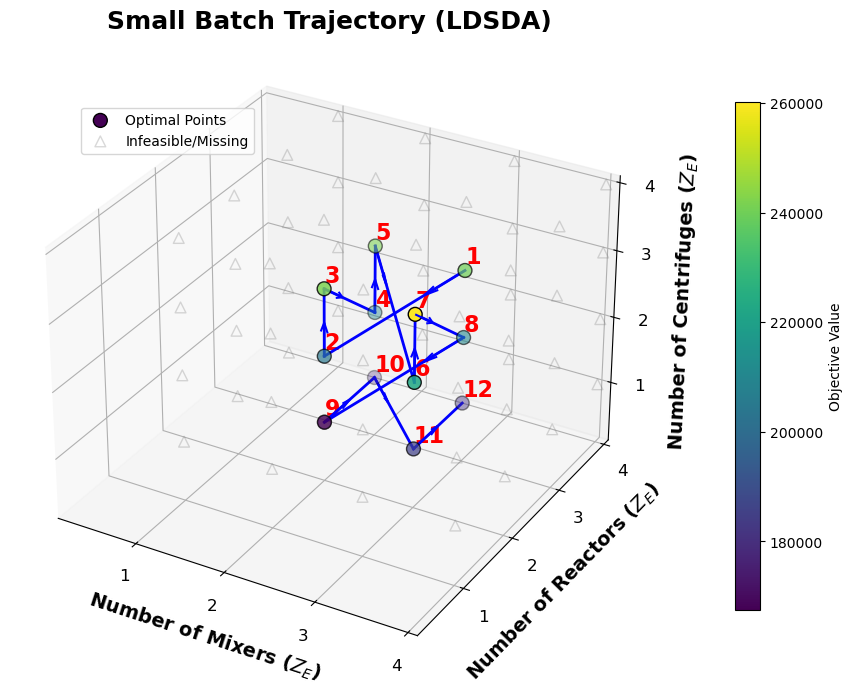

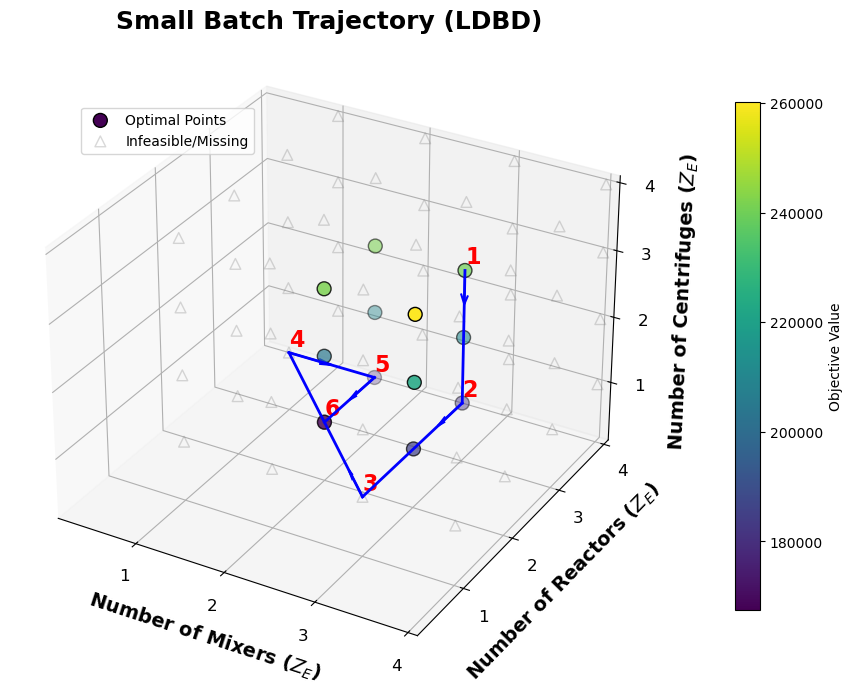

In [31]:
# Small-batch: 3D plot mimicking results/20260216/20260216.ipynb style
import os
import pandas as pd

if not SMALL_BATCH_ENUM_CSV.exists():
    raise FileNotFoundError(f"Missing small-batch landscape CSV: {SMALL_BATCH_ENUM_CSV}")

df_sb_enum = pd.read_csv(SMALL_BATCH_ENUM_CSV)

sb_points: dict[str, list[tuple[int, ...]]] = {}
for alg in _selected_algorithms():
    traj_csv = folder_path / "small_batch" / alg.lower() / "traj.csv"
    sb_points[alg] = load_traj(traj_csv)

print("Small-batch traj lengths:", {k: len(v) for k, v in sb_points.items()})

for alg, pts in sb_points.items():
    plot_3d_path_with_missing_nodes(
        df_sb_enum,
        pts,
        os.path.join(folder_path, f"small_batch_{alg.lower()}_traj_{today}.png"),
        title=f"Small Batch Trajectory ({alg})",
    )

## Column test

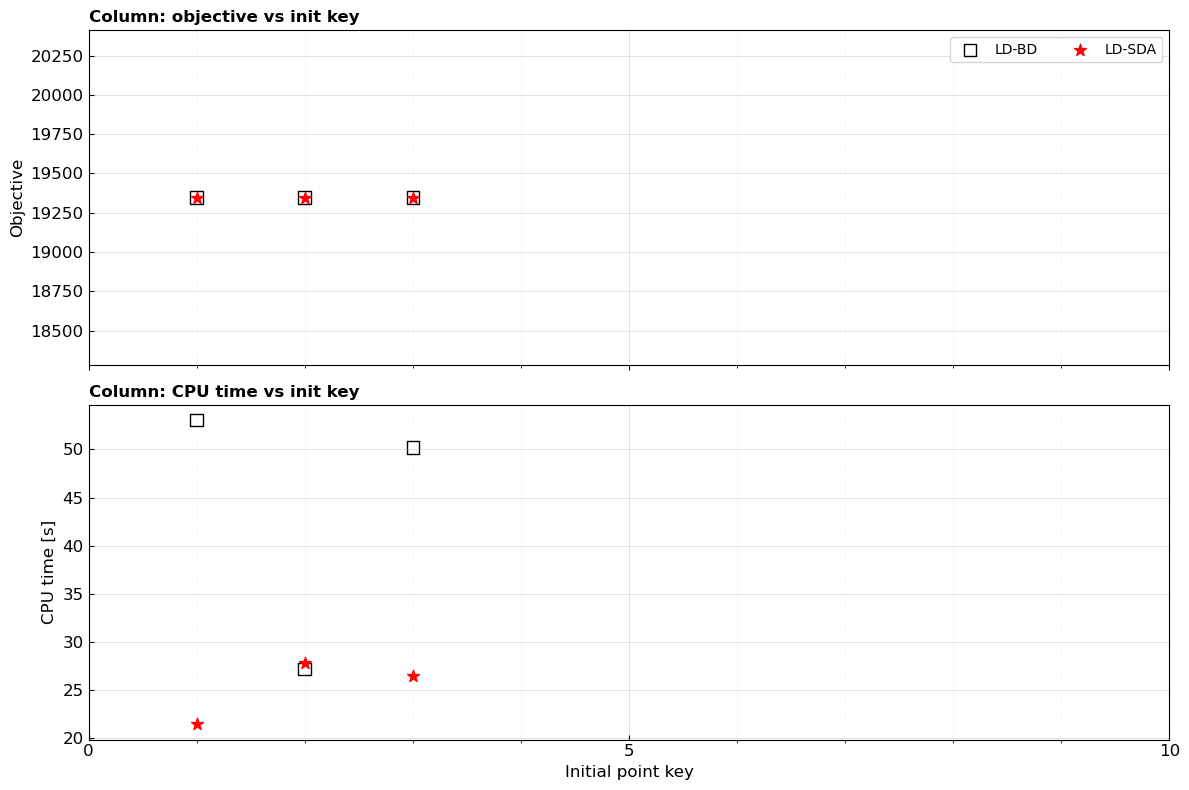

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import MultipleLocator

# Column: objective + CPU time vs initial_point_key
df_col = load_summaries_under("column")
df_col = filter_by_algorithms(df_col)
df_col = df_col[df_col.get("model", "") == "column"] if not df_col.empty and "model" in df_col.columns else df_col

if df_col.empty:
    raise FileNotFoundError("No column summary.csv found under results/<today>/column/<algo>/summary.csv")

# Prefer cpu_time_s; fallback to wall_time_s when cpu isn't populated
df_col["cpu_time"] = df_col["cpu_time_s"].where(df_col["cpu_time_s"].notna(), df_col.get("wall_time_s"))
df_col = df_col.dropna(subset=["objective_value"])
df_col = df_col.sort_values(["algorithm", "initial_point_key"])

style_map = {
    "LDSDA": {"marker": "*", "color": "red", "label": "LD-SDA"},
    "LDBD": {"marker": "s", "color": "black", "label": "LD-BD", "fillstyle": "none"},
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

def _plot_scatter(ax, y_col, include_legend=False):
    for alg in sorted(df_col["algorithm"].unique()):
        subset = df_col[df_col["algorithm"].map(_normalize_algo_tag) == _normalize_algo_tag(alg)]
        style = style_map.get(_normalize_algo_tag(alg), {"marker": "o", "color": "gray", "label": str(alg)})
        ax.scatter(
            subset["initial_point_key"],
            subset[y_col],
            marker=style["marker"],
            color=style["color"],
            label=style.get("label") if include_legend else None,
            s=80,
            facecolors=style["color"] if "fillstyle" not in style else "none",
        )

_plot_scatter(ax1, "objective_value", include_legend=True)
_plot_scatter(ax2, "cpu_time")

max_key = int(df_col["initial_point_key"].max()) if "initial_point_key" in df_col else 0
xmax = max(10, max_key + 1)

for ax in [ax1, ax2]:
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.grid(which="major", linestyle="-", linewidth=0.5, alpha=0.5)
    ax.grid(which="minor", linestyle=":", linewidth=0.5, alpha=0.3)
    ax.set_xlim(0, xmax)

ax1.tick_params(axis="y", direction="in", labelsize=12)
ax1.set_ylabel("Objective", fontsize=12)
ax1.set_title("Column: objective vs init key", loc="left", fontweight="bold")
ax1.legend(loc="upper right", ncol=2)

ax2.tick_params(axis="x", direction="in", labelsize=12)
ax2.tick_params(axis="y", direction="in", labelsize=12)
ax2.set_ylabel("CPU time [s]", fontsize=12)
ax2.set_xlabel("Initial point key", fontsize=12)
ax2.set_title("Column: CPU time vs init key", loc="left", fontweight="bold")

plt.tight_layout()
plt.show()

## CSTR Data

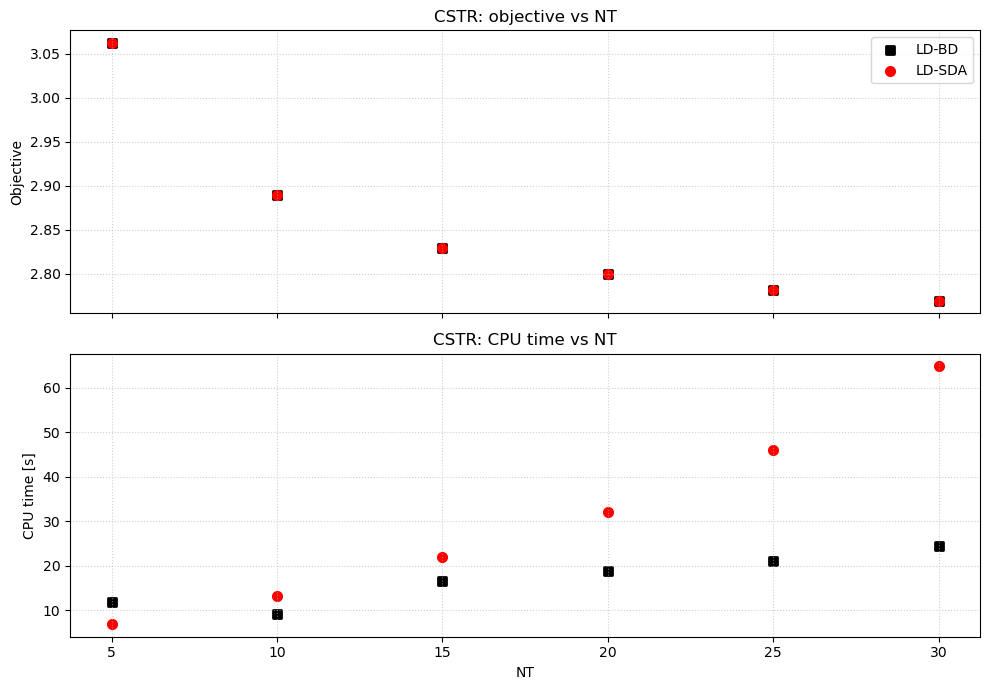

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# CSTR: objective + CPU time vs NT (from benchmark outputs)
df_cstr = load_summaries_under("cstr")
df_cstr = filter_by_algorithms(df_cstr)
df_cstr = df_cstr[df_cstr.get("model", "") == "cstr"] if not df_cstr.empty and "model" in df_cstr.columns else df_cstr

if df_cstr.empty:
    raise FileNotFoundError("No CSTR summary.csv found under results/<today>/cstr/NT*/<algo>/summary.csv")

# Extract NT from instance='NT30' (fallback to parse from file path if needed)
if "instance" in df_cstr.columns:
    nt = df_cstr["instance"].astype(str).str.extract(r"NT(\d+)")[0]
    df_cstr["NT"] = pd.to_numeric(nt, errors="coerce")
else:
    df_cstr["NT"] = None

# Prefer cpu_time_s; fallback to wall_time_s when cpu isn't populated
df_cstr["cpu_time"] = df_cstr["cpu_time_s"].where(df_cstr["cpu_time_s"].notna(), df_cstr.get("wall_time_s"))

# Drop rows without NT or objective
df_cstr = df_cstr.dropna(subset=["NT", "objective_value"])
df_cstr["NT"] = df_cstr["NT"].astype(int)

# De-duplicate reruns: keep the last row per (algorithm, NT)
df_cstr = df_cstr.sort_values(["algorithm", "NT", "__file"]).groupby(["algorithm", "NT"], as_index=False).tail(1)

style = {"LDSDA": {"color": "red", "marker": "o", "label": "LD-SDA"}, "LDBD": {"color": "black", "marker": "s", "label": "LD-BD"}}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True)
for alg in sorted(df_cstr["algorithm"].unique()):
    tag = _normalize_algo_tag(alg)
    sub = df_cstr[df_cstr["algorithm"].map(_normalize_algo_tag) == tag].sort_values("NT")
    st = style.get(tag, {"color": "gray", "marker": "o", "label": tag})
    ax1.scatter(sub["NT"], sub["objective_value"], color=st["color"], marker=st["marker"], lw=2, label=st["label"])
    ax2.scatter(sub["NT"], sub["cpu_time"], color=st["color"], marker=st["marker"], lw=2, label=st["label"])

ax1.set_ylabel("Objective")
ax1.set_title("CSTR: objective vs NT")
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend()

ax2.set_xlabel("NT")
ax2.set_ylabel("CPU time [s]")
ax2.set_title("CSTR: CPU time vs NT")
ax2.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

CSTR NT=30 traj lengths: {'LDSDA': 32, 'LDBD': 5}


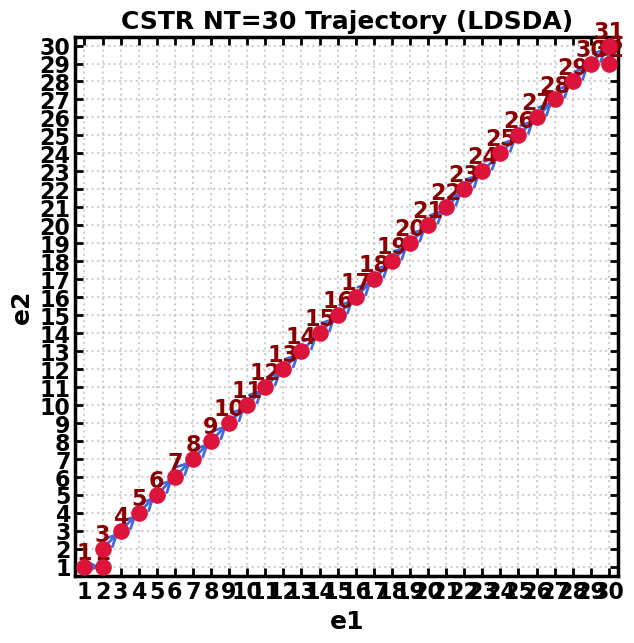

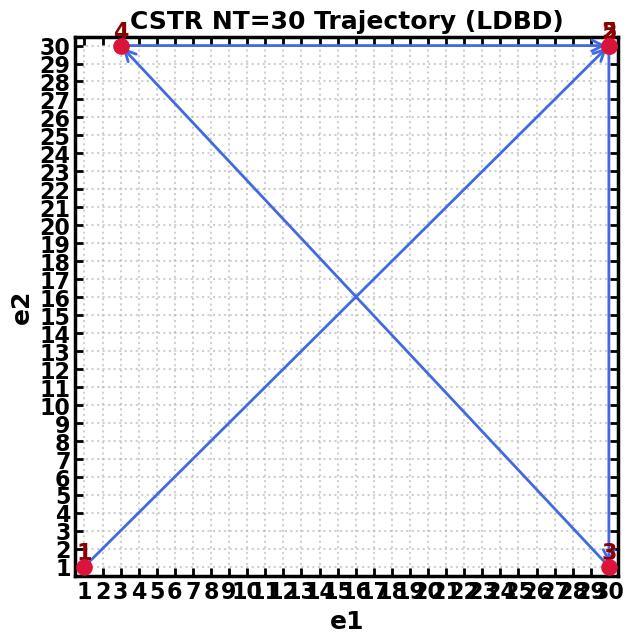

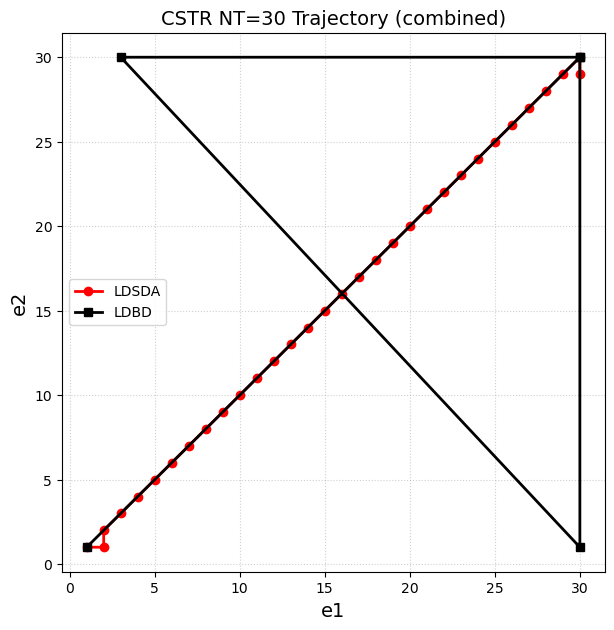

In [ ]:
import os

# CSTR: 2D path for the NT = 30 case (one algorithm or both)
cstr30_points: dict[str, list[tuple[int, ...]]] = {}
for alg in _selected_algorithms():
    traj_csv = folder_path / "cstr" / "NT30" / alg.lower() / "traj.csv"
    cstr30_points[alg] = load_traj(traj_csv)

print("CSTR NT=30 traj lengths:", {k: len(v) for k, v in cstr30_points.items()})

# Fixed axes for NT=30 grid
_cstr_xlim = (0.5, 30.5)
_cstr_ylim = (0.5, 30.5)
_cstr_ticks = list(range(1, 31))

# Per-algorithm plots (with arrows)
for alg, pts in cstr30_points.items():
    plot_point_sequence(
        pts,
        os.path.join(folder_path, f"cstr_NT30_{alg.lower()}_traj_{today}.png"),
        title=f"CSTR NT=30 Trajectory ({alg})",
        xlim=_cstr_xlim,
        ylim=_cstr_ylim,
        xticks=_cstr_ticks,
        yticks=_cstr_ticks,
    )

# Combined plot
plot_2d_paths(
    cstr30_points,
    title="CSTR NT=30 Trajectory (combined)",
    xlim=_cstr_xlim,
    ylim=_cstr_ylim,
    xticks=_cstr_ticks,
    yticks=_cstr_ticks,
 )

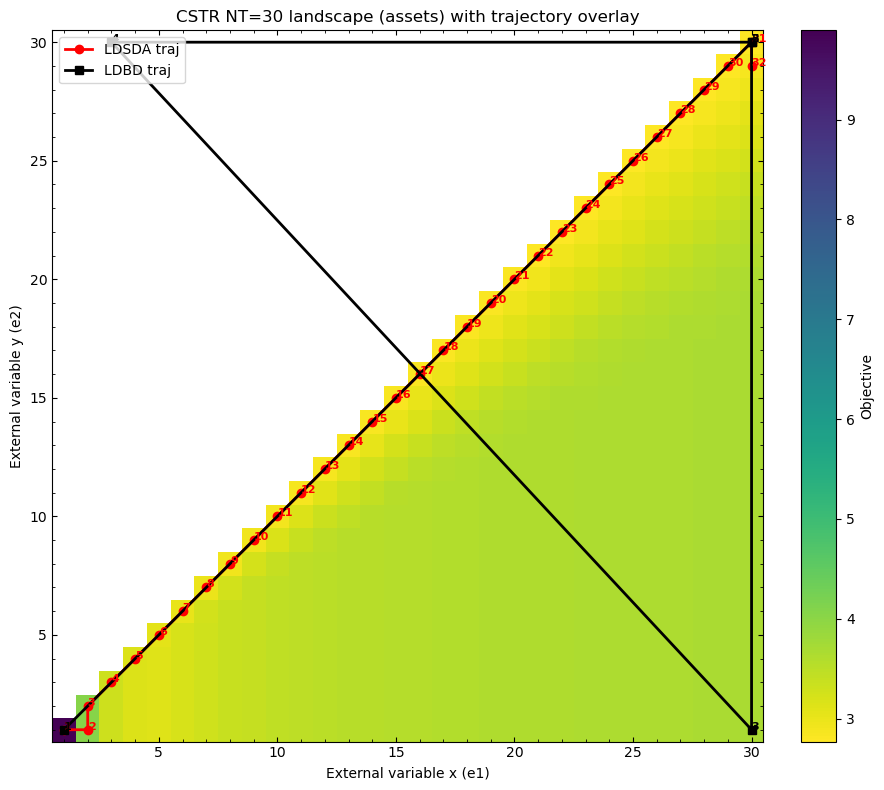

In [26]:
# CSTR NT=30: heatmap (from assets) with trajectory overlaid
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

if not CSTR_ENUM_CSV.exists():
    raise FileNotFoundError(f"Missing CSTR landscape CSV: {CSTR_ENUM_CSV}")

df_enum = pd.read_csv(CSTR_ENUM_CSV)
df_enum = df_enum.dropna(subset=["x", "y", "Objective"]).copy()
df_enum["x"] = df_enum["x"].astype(int)
df_enum["y"] = df_enum["y"].astype(int)
df_enum["Objective"] = df_enum["Objective"].astype(float)

# Pivot to grid; use min objective for duplicates
pivot_df = df_enum.pivot_table(index="y", columns="x", values="Objective", aggfunc="min")

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(
    pivot_df, origin="lower", cmap="viridis_r", aspect="equal",
    extent=[pivot_df.columns.min()-0.5, pivot_df.columns.max()+0.5, pivot_df.index.min()-0.5, pivot_df.index.max()+0.5]
 )

# Overlay trajectories
style = {"LDSDA": {"color": "red", "marker": "o"}, "LDBD": {"color": "black", "marker": "s"}}
for alg, pts in cstr30_points.items():
    if not pts:
        continue
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    st = style.get(alg, {"color": "white", "marker": "o"})
    ax.plot(xs, ys, color=st["color"], lw=2, marker=st["marker"], label=f"{alg} traj")
    for k, (x, y) in enumerate(pts, start=1):
        ax.text(x, y, str(k), color=st["color"], fontsize=8, fontweight="bold")

ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
ax.set_xlabel("External variable x (e1)")
ax.set_ylabel("External variable y (e2)")
ax.set_title("CSTR NT=30 landscape (assets) with trajectory overlay")
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Objective")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

* Local Sensitivity (Numerical Annotations): 
  * Each cell is annotated with an integer representing the order of magnitude of the minimum difference between that cell and its eight immediate neighbors.
  * Higher negative values (e.g., $-6$ to $-10$) indicate "flat" regions where the objective function is highly stable and changes very little with respect to the external variables.
  * Lower negative values (e.g., $-2$ or $-3$) highlight regions with steeper gradients or higher local sensitivity.

## CSTR Traj

In [25]:
# Optional: show the per-NT summary rows for NT=30 (for selected algorithms)
import pandas as pd

NT = 30
for alg in _selected_algorithms():
    sum_path = folder_path / "cstr" / f"NT{NT}" / alg.lower() / "summary.csv"
    if sum_path.exists():
        print(f"Summary for {alg} (NT={NT}):")
        display(pd.read_csv(sum_path))

Summary for LDSDA (NT=30):


,model,instance,algorithm,algorithm_full,initial_point_key,starting_point,objective_value,wall_time_s,cpu_time_s,termination_condition,solver_status
0,cstr,NT30,LDSDA,gdpopt.ldsda,NaN,"(1, 1)",2.76957,64.764003,64.76245,unknown,ok


Summary for LDBD (NT=30):


,model,instance,algorithm,algorithm_full,initial_point_key,starting_point,objective_value,wall_time_s,cpu_time_s,termination_condition,solver_status
0,cstr,NT30,LDBD,gdpopt.ldbd,NaN,"(1, 1)",2.76957,24.354132,24.351897,optimal,ok
